## Plot probe insertions by day 
This notebook allows you to plot all the Neuropixel recordings you made in a mouse and indicate on which day with which probe they were made. This allows you to find out which traces in histology belong to which recording.

Some imports and setup

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from one.api import ONE
one = ONE()

Here input the name of your animal:

In [6]:
SUBJECT = 'ZFM-01867'

The script will hit the database, find all recordings for this animal and plot them.

Index(['id', 'probe_insertion', 'x', 'y', 'z', 'depth', 'theta', 'phi', 'roll',
       'provenance', 'session', 'probe_name', 'coordinate_system', 'datetime',
       'json'],
      dtype='object')


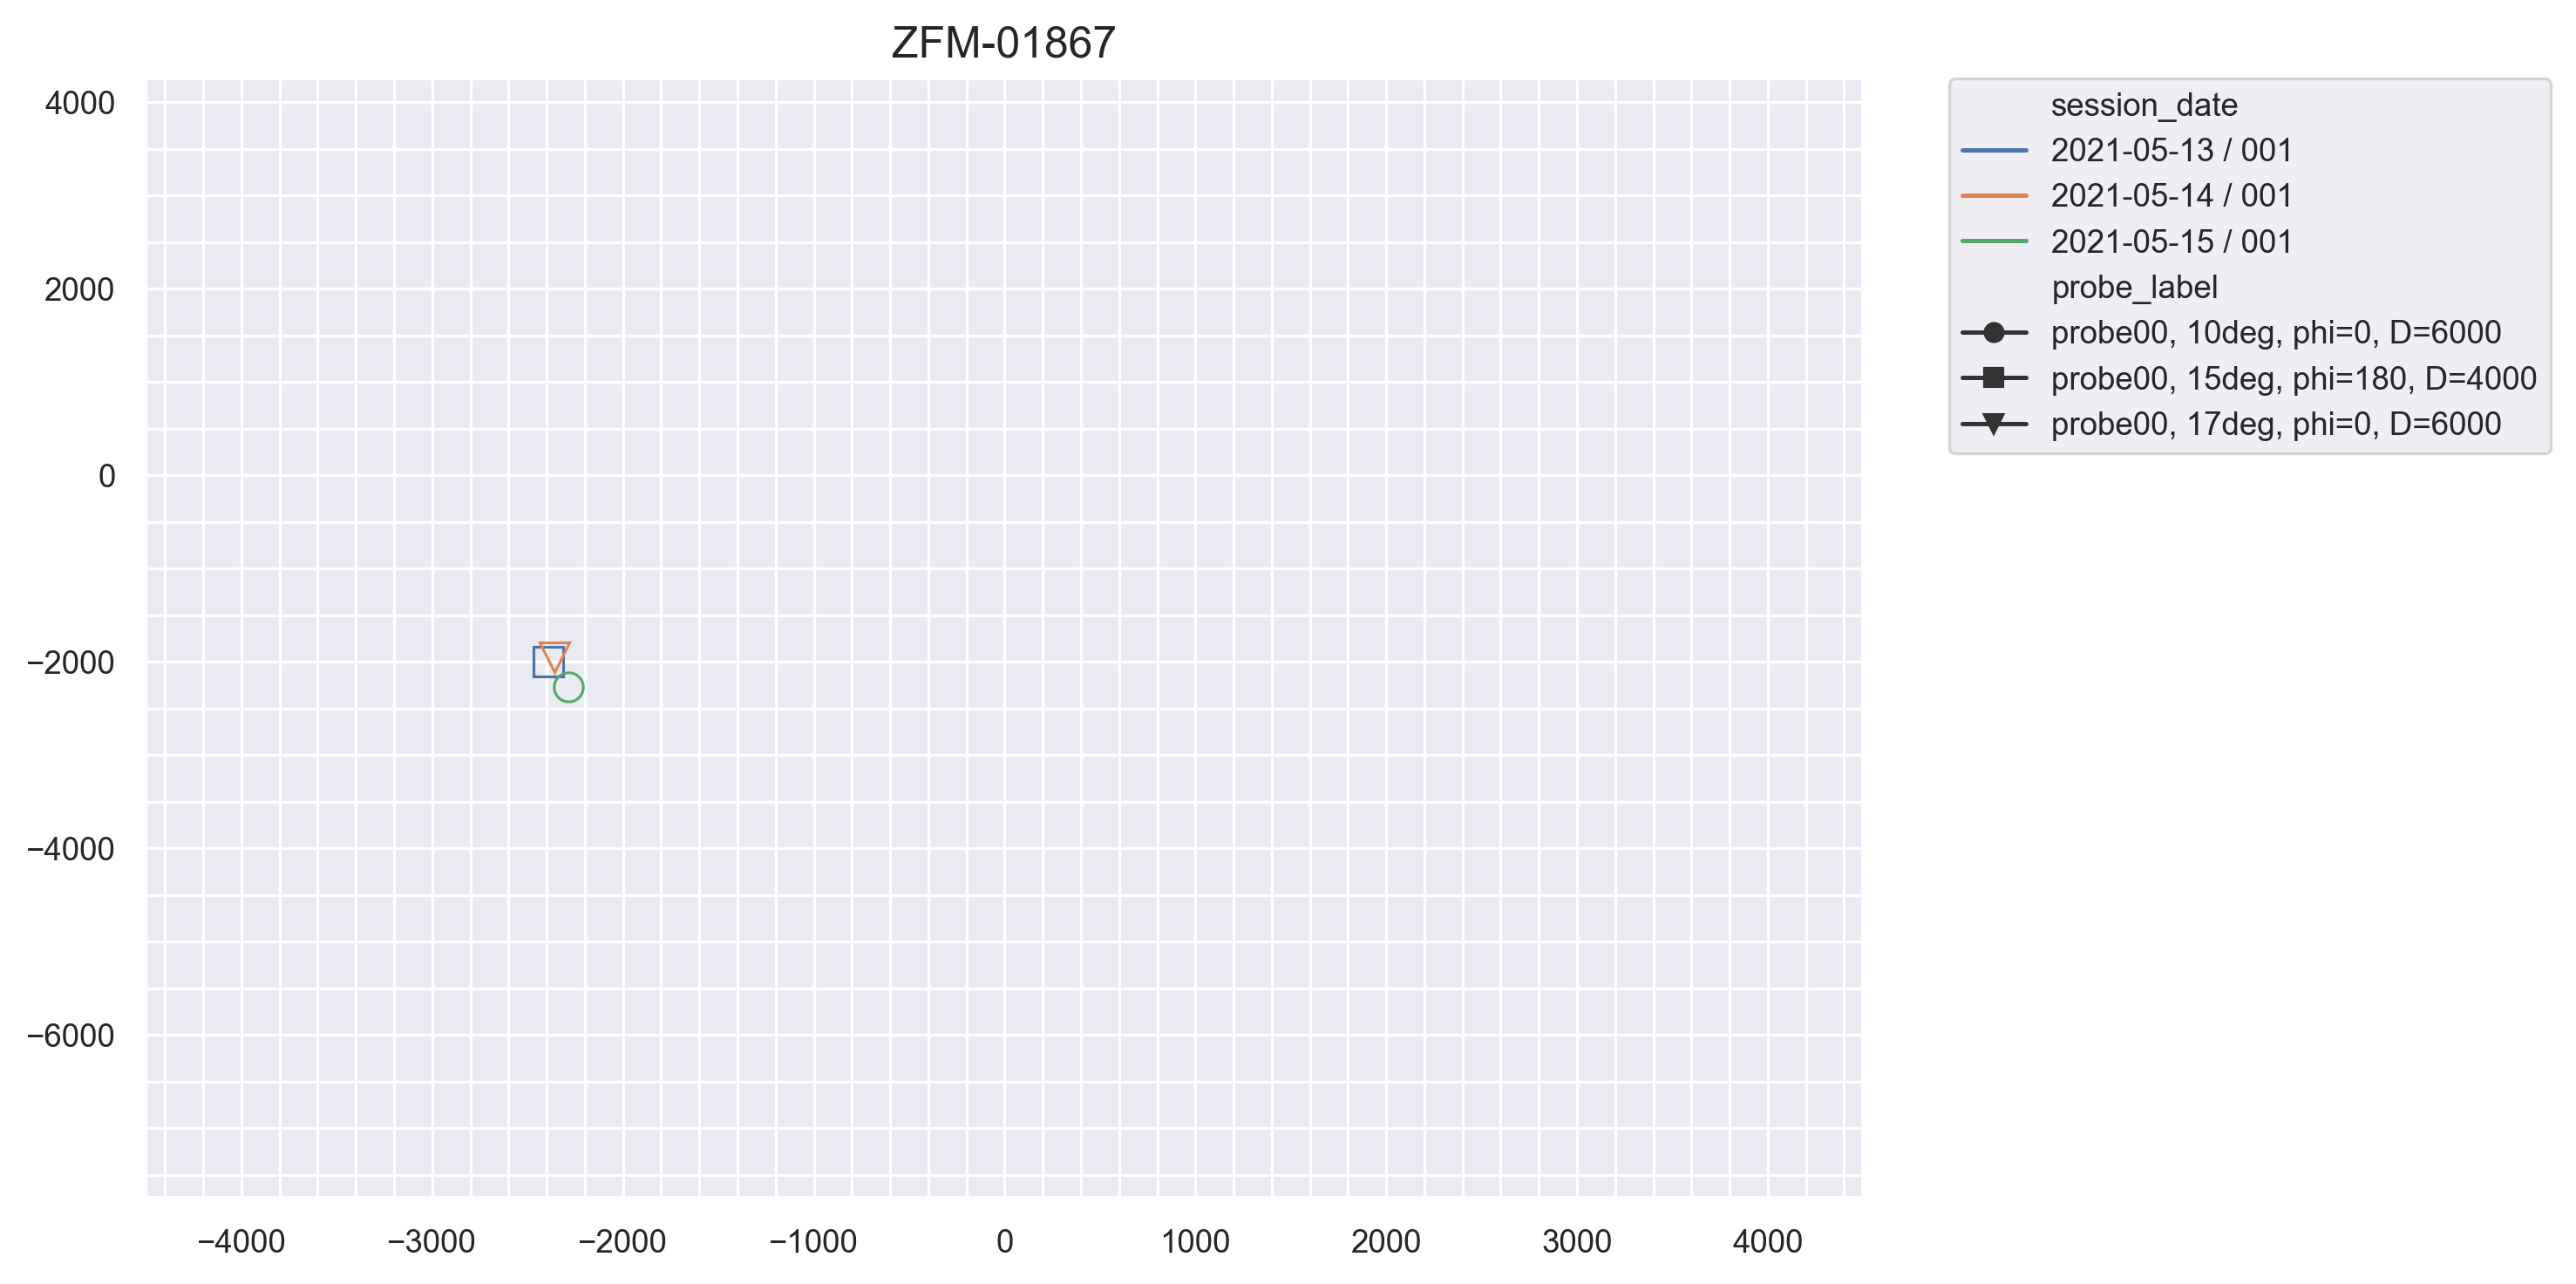

In [8]:
trajs = one.alyx.rest('trajectories', 'list', provenance='micro-manipulator')
traj = pd.DataFrame(list(trajs))
print(traj.columns)

# get the subject info out of the 'session' column
for kix, k in enumerate(traj.session[0].keys()):
    tmp_var = []
    for id, c in traj.iterrows():
        if k in c['session'].keys():
            tmp = c['session'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
        # also add the date
    traj[k] = tmp_var

# some renaming
traj['theta_name'] = traj['theta'].map({0: '0deg', 10:'10deg', 15:'15deg', 17:'17deg'})

traj['depth'] = round(traj.depth, -3) # round to nearest 1000
traj['probe_label'] = traj.probe_name + ', ' + traj.theta_name + ', phi=' + traj.phi.astype(int).astype(str) + ', D=' + traj.depth.astype(int).astype(str)
traj['session_date'] = traj['start_time'].str[0:10]

traj['number'] = traj['number'].fillna(0)
traj['number'] = traj['number'].astype(int)
traj['session_date'] = traj['session_date'].astype(str) + ' / 00' + traj['number'].astype(str)

traj['subject_nickname'] = traj['subject']
traj = traj.sort_values(by=['subject_nickname'])
traj_mm = traj.copy()
# traj.head(n=5)

# %% plot
sns.set(style="darkgrid", context="paper")
markers = ['o', 's', 'v', 'D', 'X', '^', '*', 'h', 'H',  'd', 'p', 'P']

f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
df = traj[traj.subject_nickname==SUBJECT]
sns.lineplot(data=df, x='x', y='y', hue="session_date", style="probe_label",
             hue_order=sorted(df.session_date.unique()),
             style_order=sorted(df.probe_label.dropna().unique()), linewidth=0,
             markers=markers[:len(df.probe_label.unique())], markersize=8, mfc='none', mec='auto',
             ax=ax, legend='full', dashes=False)

ax.set_title(SUBJECT, fontsize=12)
ax.set(xlim=[-4500, 4500], ylim=[-7750, 4250], xlabel='', ylabel='')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()